In [10]:
import tensorflow as tf
from tensorflow.keras import layers

latent_dim = 64

# Encoder
encoder_inputs = tf.keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean_layer")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var_layer")(x)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


In [11]:
batch_size = 16  # Or even smaller


In [12]:
img_size = (64, 64)  # Adjust as needed


In [14]:
import os
import cv2
import numpy as np

data_dir = 'C:/Users/rahma/DogImages/images'
img_size = (128, 128)

def load_images(data_dir, img_size):
    images = []
    count = 0
    for root, dirs, files in os.walk(data_dir):
        for filename in files:
            img_path = os.path.join(root, filename)
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
            count += 1
            if count % 100 == 0:
                print(f"{count} images loaded...")
    images = np.array(images, dtype='float32') / 255.0
    return images

images = load_images(data_dir, img_size)
print(f"Total images loaded: {len(images)}")


100 images loaded...
200 images loaded...
300 images loaded...
400 images loaded...
500 images loaded...
600 images loaded...
700 images loaded...
800 images loaded...
900 images loaded...
1000 images loaded...
1100 images loaded...
1200 images loaded...
1300 images loaded...
1400 images loaded...
1500 images loaded...
1600 images loaded...
1700 images loaded...
1800 images loaded...
1900 images loaded...
2000 images loaded...
2100 images loaded...
2200 images loaded...
2300 images loaded...
2400 images loaded...
2500 images loaded...
2600 images loaded...
2700 images loaded...
2800 images loaded...
2900 images loaded...
3000 images loaded...
3100 images loaded...
3200 images loaded...
3300 images loaded...
3400 images loaded...
3500 images loaded...
3600 images loaded...
3700 images loaded...
3800 images loaded...
3900 images loaded...
4000 images loaded...
4100 images loaded...
4200 images loaded...
4300 images loaded...
4400 images loaded...
4500 images loaded...
4600 images loaded.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode=None)

#vae.fit(train_generator, epochs=50)


Found 20580 images belonging to 1 classes.


In [16]:
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D()(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")


In [34]:
class CustomVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CustomVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Define losses
        reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(reconstructed))
        reconstruction_loss *= 128 * 128 * 3
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss) * -0.5
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        self.add_loss(total_loss)
        return reconstructed

vae = CustomVAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [19]:
# Assuming `images` contains your preprocessed dog images
epochs = 40
batch_size = 32
for epoch in range(epochs):
    for i in range(0, len(images), batch_size):
        x_batch = images[i:i + batch_size]
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch)
            loss = sum(vae.losses)
            grads = tape.gradient(loss, vae.trainable_weights)
            vae.optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}")


Epoch 1/40, Loss: 31716.01171875
Epoch 2/40, Loss: 31276.576171875
Epoch 3/40, Loss: 31039.75
Epoch 4/40, Loss: 30936.44140625
Epoch 5/40, Loss: 30886.73828125
Epoch 6/40, Loss: 30812.697265625
Epoch 7/40, Loss: 30754.013671875
Epoch 8/40, Loss: 30700.869140625
Epoch 9/40, Loss: 30652.51171875
Epoch 10/40, Loss: 30597.572265625
Epoch 11/40, Loss: 30544.642578125
Epoch 12/40, Loss: 30495.873046875
Epoch 13/40, Loss: 30451.33984375
Epoch 14/40, Loss: 30415.849609375
Epoch 15/40, Loss: 30387.921875
Epoch 16/40, Loss: 30348.4921875
Epoch 17/40, Loss: 30324.232421875
Epoch 18/40, Loss: 30308.501953125
Epoch 19/40, Loss: 30292.6171875
Epoch 20/40, Loss: 30259.390625
Epoch 21/40, Loss: 30253.94140625
Epoch 22/40, Loss: 30239.2421875
Epoch 23/40, Loss: 30227.6171875
Epoch 24/40, Loss: 30206.845703125
Epoch 25/40, Loss: 30218.876953125
Epoch 26/40, Loss: 30198.3984375
Epoch 27/40, Loss: 30192.19921875
Epoch 28/40, Loss: 30170.044921875
Epoch 29/40, Loss: 30164.388671875
Epoch 30/40, Loss: 30157

In [ ]:
# Model checkpoint
#checkpoint = tf.keras.callbacks.ModelCheckpoint('vae_checkpoint.keras', save_best_only=True)
#vae.fit(train_generator, epochs=epochs, callbacks=[checkpoint])


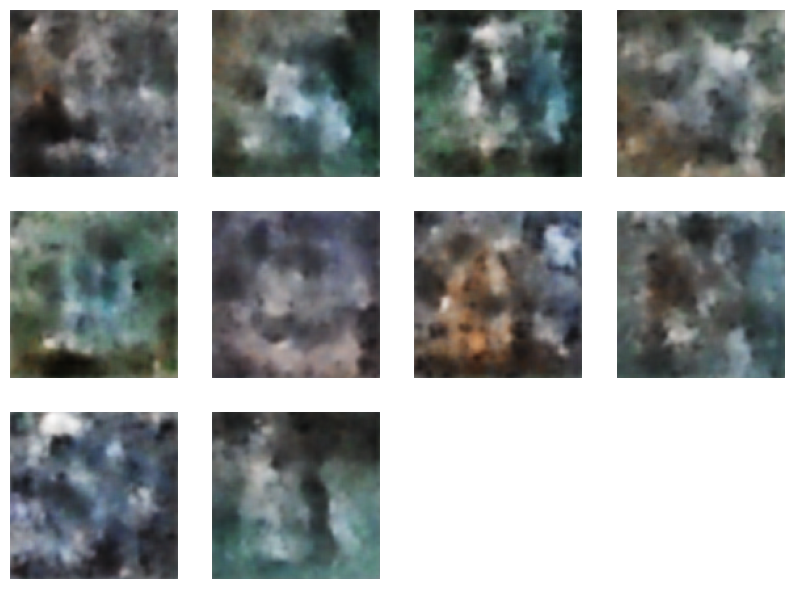

In [20]:
# Generate images using the trained VAE
latent_samples = tf.random.normal(shape=(10, latent_dim))
generated_images = decoder(latent_samples)

import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

plot_images(generated_images)
